# Experiment 8 - look at accuracies and PS as a function of number of practiced tasks trained

In [2]:
import numpy as np
import torch
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from model import analysis
from model import task
from importlib import reload
import tools
import pandas as pd
analysis = reload(analysis)
sns.set_style("whitegrid")

In [3]:
datadir = '../../data/model_results/experiment8/'
palette = sns.color_palette("Set2")


#### Sample commands for 3 networks
`python experiment8_accuracyBenchmarkComparison.py --acc_cutoff 90 --nepochs 0 --pretraining --practice --cuda --verbose --nsimulations 40`

`python experiment8_accuracyBenchmarkComparison.py --acc_cutoff 90 --nepochs 0 --rule2pretraining --practice --cuda --verbose --nsimulations 40`

`python experiment8_accuracyBenchmarkComparison.py --acc_cutoff 90 --nepochs 0 --practice --cuda --verbose --nsimulations 40`

# Load data

In [120]:
simstart = 0
simend = 40

# df_sgd = pd.read_csv(datadir + 'expt5_sgd_150epochs_2layers_pretraining_posneg_practice_simData0.csv')
# df_sgd.insert(len(df_sgd.columns),"Simulation",list(np.repeat(0,len(df_sgd))),True)
#
df_adam = pd.read_csv(datadir + 'expt8_adam_90accCutOff_2layers_2rulepretraining_practice_simData' + str(simstart) + '.csv')
df_adam.insert(len(df_adam.columns),"Simulation",list(np.repeat(simstart,len(df_adam))),True)
#
df_adam_1rule = pd.read_csv(datadir + 'expt8_adam_90accCutOff_2layers_pretraining_practice_simData' + str(simstart) + '.csv')
df_adam_1rule.insert(len(df_adam_1rule.columns),"Simulation",list(np.repeat(simstart,len(df_adam_1rule))),True)
#
df_adam_nopretraining = pd.read_csv(datadir + 'expt8_adam_90accCutOff_2layers_practice_simData' + str(simstart) + '.csv')
df_adam_nopretraining.insert(len(df_adam_nopretraining.columns),"Simulation",list(np.repeat(simstart,len(df_adam_nopretraining))),True)

for i in range(simstart + 1,simend):
#     tmp = pd.read_csv(datadir + 'expt5_sgd_150epochs_2layers_pretraining_posneg_practice_simData' + str(i) + '.csv')
#     tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
#     df_sgd = df_sgd.append(tmp)
    #
    tmp = pd.read_csv(datadir + 'expt8_adam_90accCutOff_2layers_2rulepretraining_practice_simData' + str(i) + '.csv')
    tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
    df_adam = df_adam.append(tmp)
    #
    tmp = pd.read_csv(datadir + 'expt8_adam_90accCutOff_2layers_pretraining_practice_simData' + str(i) + '.csv')
    tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
    df_adam_1rule = df_adam_1rule.append(tmp)
    #
    tmp = pd.read_csv(datadir + 'expt8_adam_90accCutOff_2layers_practice_simData' + str(i) + '.csv')
    tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
    df_adam_nopretraining = df_adam_nopretraining.append(tmp)

# Transform accuracies to out of 100%
df_adam_nopretraining.Accuracy = df_adam_nopretraining.Accuracy.values * 100.0
df_adam.Accuracy = df_adam.Accuracy.values * 100.0
df_adam_1rule.Accuracy = df_adam_1rule.Accuracy.values * 100.0

##########
# Calculate total number of training samples/trials per simulation
total_trials = []
for i in range(len(df_adam)):
    total_trials.append(df_adam.iloc[i].NumPretrainingTrials + df_adam.iloc[i].NumActualTrials)
df_adam['TotalTrials'] = total_trials

total_trials = []
for i in range(len(df_adam_1rule)):
    total_trials.append(df_adam_1rule.iloc[i].NumPretrainingTrials + df_adam_1rule.iloc[i].NumActualTrials)
df_adam_1rule['TotalTrials'] = total_trials

total_trials = []
for i in range(len(df_adam_nopretraining)):
    total_trials.append(df_adam_nopretraining.iloc[i].NumPretrainingTrials + df_adam_nopretraining.iloc[i].NumActualTrials)
df_adam_nopretraining['TotalTrials'] = total_trials


## Accuracy vs. number of practiced tasks

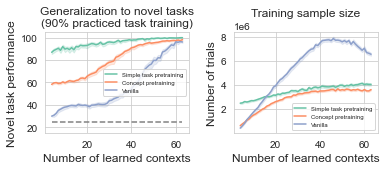

In [133]:
# prac_acc = df.loc[df['Condition']=='Practiced']
# rule2_acc = df.loc[df['Condition']=='2-rule overlap']
# rule1_acc = df.loc[df['Condition']=='1-rule overlap']
plt.figure(figsize=(5.5,2.5))
plt.subplot(1,2,1)
sns.lineplot(x="NumPracticedTasks",y="Accuracy",data=df_adam,color=palette[0],label='Simple task pretraining')
sns.lineplot(x="NumPracticedTasks",y="Accuracy",data=df_adam_1rule,color=palette[1],label='Concept pretraining')
sns.lineplot(x="NumPracticedTasks",y="Accuracy",data=df_adam_nopretraining,color=palette[2],label='Vanilla')
plt.plot(np.arange(4,64),np.repeat(25,len(np.arange(4,64))),'gray',linestyle='--')
# plt.plot(np.arange(4,64),np.repeat(.80,len(np.arange(4,64))),'r',linestyle='--',label='Training cut-off on practice')
plt.title('Generalization to novel tasks\n(90% practiced task training)', fontsize=12)
plt.xlabel('Number of learned contexts', fontsize=12)
plt.ylabel('Novel task performance', fontsize=12)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10);
plt.ylim([15,105])
plt.legend(fontsize=6)

plt.subplot(1,2,2)
sns.lineplot(x="NumPracticedTasks",y="TotalTrials",data=df_adam,color=palette[0],label='Simple task pretraining')
sns.lineplot(x="NumPracticedTasks",y="TotalTrials",data=df_adam_1rule,color=palette[1],label='Concept pretraining')
sns.lineplot(x="NumPracticedTasks",y="TotalTrials",data=df_adam_nopretraining,color=palette[2],label='Vanilla')
# plt.plot(np.arange(4,64),np.repeat(.80,len(np.arange(4,64))),'r',linestyle='--',label='Training cut-off on practice')
plt.title('Training sample size', fontsize=12,y=1.1)
plt.xlabel('Number of learned contexts', fontsize=12)
plt.ylabel('Number of trials', fontsize=12)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10);
plt.legend(fontsize=6)
plt.tight_layout()
plt.savefig('Expt8b_90accCutOff.png',dpi=300)

# PS analysis

#### Average PS across all domains

In [122]:
df_psavg = {}
df_psavg['PS1'] = []
df_psavg['PS2'] = []
df_psavg['PSavg'] = []
df_psavg['Simulation'] = []
df_psavg['NumPracticedTasks'] = []
df_psavg['Accuracy'] = []
df_psavg['Training'] = []
for i in range(simstart,simend):
    tmpdf = df_adam.loc[df_adam.Simulation==i]
    df_psavg['Simulation'].extend(np.repeat(i,len(tmpdf)))
    avgps1 = (tmpdf.LogicPS1.values + tmpdf.SensoryPS1.values + tmpdf.MotorPS1.values)/3.0
    df_psavg['PS1'].extend(avgps1)
    avgps2 = (tmpdf.LogicPS2.values + tmpdf.SensoryPS2.values + tmpdf.MotorPS2.values)/3.0
    df_psavg['PS2'].extend(avgps2)
    df_psavg['PSavg'].extend((avgps1+avgps2)/2.0)
    df_psavg['NumPracticedTasks'].extend(tmpdf.NumPracticedTasks.values)
    df_psavg['Accuracy'].extend(tmpdf.Accuracy.values)
    df_psavg['Training'].extend(np.repeat('Adam 2-rule pretraining',len(tmpdf)))

    
    tmpdf = df_adam_nopretraining.loc[df_adam_nopretraining.Simulation==i]
    df_psavg['Simulation'].extend(np.repeat(i,len(tmpdf)))
    avgps1 = (tmpdf.LogicPS1.values + tmpdf.SensoryPS1.values + tmpdf.MotorPS1.values)/3.0
    df_psavg['PS1'].extend(avgps1)
    avgps2 = (tmpdf.LogicPS2.values + tmpdf.SensoryPS2.values + tmpdf.MotorPS2.values)/3.0
    df_psavg['PS2'].extend(avgps2)
    df_psavg['PSavg'].extend((avgps1+avgps2)/2.0)
    df_psavg['NumPracticedTasks'].extend(tmpdf.NumPracticedTasks.values)
    df_psavg['Accuracy'].extend(tmpdf.Accuracy.values)
    df_psavg['Training'].extend(np.repeat('Adam no pretraining',len(tmpdf)))
    
    tmpdf = df_adam_1rule.loc[df_adam_1rule.Simulation==i]
    df_psavg['Simulation'].extend(np.repeat(i,len(tmpdf)))
    avgps1 = (tmpdf.LogicPS1.values + tmpdf.SensoryPS1.values + tmpdf.MotorPS1.values)/3.0
    df_psavg['PS1'].extend(avgps1)
    avgps2 = (tmpdf.LogicPS2.values + tmpdf.SensoryPS2.values + tmpdf.MotorPS2.values)/3.0
    df_psavg['PS2'].extend(avgps2)
    df_psavg['PSavg'].extend((avgps1+avgps2)/2.0)
    df_psavg['NumPracticedTasks'].extend(tmpdf.NumPracticedTasks.values)
    df_psavg['Accuracy'].extend(tmpdf.Accuracy.values)
    df_psavg['Training'].extend(np.repeat('Adam 1-rule pretraining',len(tmpdf)))

df_psavg = pd.DataFrame(df_psavg)

# Compare accuracy x PS scores

In [123]:
df_adam0 = pd.read_csv(datadir + 'expt8_adam_zeroshot_2layers_2rulepretraining_simData' + str(simstart) + '.csv')
df_adam0.insert(len(df_adam0.columns),"Simulation",list(np.repeat(simstart,len(df_adam0))),True)
#
df_adam0_1rule = pd.read_csv(datadir + 'expt8_adam_zeroshot_2layers_pretraining_simData' + str(simstart) + '.csv')
df_adam0_1rule.insert(len(df_adam0_1rule.columns),"Simulation",list(np.repeat(simstart,len(df_adam0_1rule))),True)
#
df_adam0_nopretraining = pd.read_csv(datadir + 'expt8_adam_zeroshot_2layers_simData' + str(simstart) + '.csv')
df_adam0_nopretraining.insert(len(df_adam0_nopretraining.columns),"Simulation",list(np.repeat(simstart,len(df_adam0_nopretraining))),True)

for i in range(simstart+1,simend):
    #
    tmp = pd.read_csv(datadir + 'expt8_adam_zeroshot_2layers_2rulepretraining_simData' + str(i) + '.csv')
    tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
    df_adam0 = df_adam0.append(tmp)
    #
    tmp = pd.read_csv(datadir + 'expt8_adam_zeroshot_2layers_pretraining_simData' + str(i) + '.csv')
    tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
    df_adam0_1rule = df_adam0_1rule.append(tmp)
    #
    tmp = pd.read_csv(datadir + 'expt8_adam_zeroshot_2layers_simData' + str(i) + '.csv')
    tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
    df_adam0_nopretraining = df_adam0_nopretraining.append(tmp)
    
df_adam0.Accuracy = df_adam0.Accuracy.values*100.0
df_adam0_1rule.Accuracy = df_adam0_1rule.Accuracy.values*100.0
df_adam0_nopretraining.Accuracy = df_adam0_nopretraining.Accuracy.values*100.0

In [124]:
df_psavg0 = {}
df_psavg0['LogicPS1'] = []
df_psavg0['LogicPS2'] = []
df_psavg0['LogicPSavg'] = []
df_psavg0['SensoryPS1'] = []
df_psavg0['SensoryPS2'] = []
df_psavg0['SensoryPSavg'] = []
df_psavg0['MotorPS1'] = []
df_psavg0['MotorPS2'] = []
df_psavg0['MotorPSavg'] = []
df_psavg0['PS1'] = []
df_psavg0['PS2'] = []
df_psavg0['PSavg'] = []
df_psavg0['Simulation'] = []
df_psavg0['NumPracticedTasks'] = []
df_psavg0['Accuracy'] = []
df_psavg0['Training'] = []
for i in range(simstart,simend):
    # Get 0 practiced tasks data
    tmpdf = df_adam0.loc[df_adam0.Simulation==i]
    tmpdf = tmpdf.loc[tmpdf.NumPracticedTasks==0]
    df_psavg0['Simulation'].extend(np.repeat(i,len(tmpdf)))
    avgps1 = (tmpdf.LogicPS1.values + tmpdf.SensoryPS1.values + tmpdf.MotorPS1.values)/3.0
    df_psavg0['PS1'].extend(avgps1)
    avgps2 = (tmpdf.LogicPS2.values + tmpdf.SensoryPS2.values + tmpdf.MotorPS2.values)/3.0
    df_psavg0['PS2'].extend(avgps2)
    df_psavg0['PSavg'].extend((avgps1+avgps2)/2.0)
    #
    df_psavg0['LogicPS1'].extend(tmpdf.LogicPS1.values)
    df_psavg0['LogicPS2'].extend(tmpdf.LogicPS2.values)
    df_psavg0['LogicPSavg'].extend((tmpdf.LogicPS2.values+tmpdf.LogicPS1.values)/2.0)
    #
    df_psavg0['SensoryPS1'].extend(tmpdf.SensoryPS1.values)
    df_psavg0['SensoryPS2'].extend(tmpdf.SensoryPS2.values)
    df_psavg0['SensoryPSavg'].extend((tmpdf.SensoryPS1.values+tmpdf.SensoryPS2.values)/2.0)
    #
    df_psavg0['MotorPS1'].extend(tmpdf.MotorPS1.values)
    df_psavg0['MotorPS2'].extend(tmpdf.MotorPS2.values)
    df_psavg0['MotorPSavg'].extend((tmpdf.MotorPS1.values+tmpdf.MotorPS2.values)/2.0)
    #
    df_psavg0['NumPracticedTasks'].extend(tmpdf.NumPracticedTasks.values)
    df_psavg0['Accuracy'].extend(tmpdf.Accuracy.values)
    df_psavg0['Training'].extend(np.repeat('2-rule pretraining',len(tmpdf)))
    
    tmpdf = df_adam0_1rule.loc[df_adam0_1rule.Simulation==i]
    tmpdf = tmpdf.loc[tmpdf.NumPracticedTasks==0]
    df_psavg0['Simulation'].extend(np.repeat(i,len(tmpdf)))
    avgps1 = (tmpdf.LogicPS1.values + tmpdf.SensoryPS1.values + tmpdf.MotorPS1.values)/3.0
    df_psavg0['PS1'].extend(avgps1)
    avgps2 = (tmpdf.LogicPS2.values + tmpdf.SensoryPS2.values + tmpdf.MotorPS2.values)/3.0
    df_psavg0['PS2'].extend(avgps2)
    df_psavg0['PSavg'].extend((avgps1+avgps2)/2.0)
    #
    df_psavg0['LogicPS1'].extend(tmpdf.LogicPS1.values)
    df_psavg0['LogicPS2'].extend(tmpdf.LogicPS2.values)
    df_psavg0['LogicPSavg'].extend((tmpdf.LogicPS2.values+tmpdf.LogicPS1.values)/2.0)
    #
    df_psavg0['SensoryPS1'].extend(tmpdf.SensoryPS1.values)
    df_psavg0['SensoryPS2'].extend(tmpdf.SensoryPS2.values)
    df_psavg0['SensoryPSavg'].extend((tmpdf.SensoryPS1.values+tmpdf.SensoryPS2.values)/2.0)
    #
    df_psavg0['MotorPS1'].extend(tmpdf.MotorPS1.values)
    df_psavg0['MotorPS2'].extend(tmpdf.MotorPS2.values)
    df_psavg0['MotorPSavg'].extend((tmpdf.MotorPS1.values+tmpdf.MotorPS2.values)/2.0)
    #
    df_psavg0['NumPracticedTasks'].extend(tmpdf.NumPracticedTasks.values)
    df_psavg0['Accuracy'].extend(tmpdf.Accuracy.values)
    df_psavg0['Training'].extend(np.repeat('1-rule pretraining',len(tmpdf)))
    
    
    tmpdf = df_adam0_nopretraining.loc[df_adam0_nopretraining.Simulation==i]
    tmpdf = tmpdf.loc[tmpdf.NumPracticedTasks==0]
    df_psavg0['Simulation'].extend(np.repeat(i,len(tmpdf)))
    avgps1 = (tmpdf.LogicPS1.values + tmpdf.SensoryPS1.values + tmpdf.MotorPS1.values)/3.0
    df_psavg0['PS1'].extend(avgps1)
    avgps2 = (tmpdf.LogicPS2.values + tmpdf.SensoryPS2.values + tmpdf.MotorPS2.values)/3.0
    df_psavg0['PS2'].extend(avgps2)
    df_psavg0['PSavg'].extend((avgps1+avgps2)/2.0)
    #
    df_psavg0['LogicPS1'].extend(tmpdf.LogicPS1.values)
    df_psavg0['LogicPS2'].extend(tmpdf.LogicPS2.values)
    df_psavg0['LogicPSavg'].extend((tmpdf.LogicPS2.values+tmpdf.LogicPS1.values)/2.0)
    #
    df_psavg0['SensoryPS1'].extend(tmpdf.SensoryPS1.values)
    df_psavg0['SensoryPS2'].extend(tmpdf.SensoryPS2.values)
    df_psavg0['SensoryPSavg'].extend((tmpdf.SensoryPS1.values+tmpdf.SensoryPS2.values)/2.0)
    #
    df_psavg0['MotorPS1'].extend(tmpdf.MotorPS1.values)
    df_psavg0['MotorPS2'].extend(tmpdf.MotorPS2.values)
    df_psavg0['MotorPSavg'].extend((tmpdf.MotorPS1.values+tmpdf.MotorPS2.values)/2.0)
    #
    df_psavg0['NumPracticedTasks'].extend(tmpdf.NumPracticedTasks.values)
    df_psavg0['Accuracy'].extend(tmpdf.Accuracy.values)
    df_psavg0['Training'].extend(np.repeat('No pretraining',len(tmpdf)))
    
    #### Get 64 practiced tasks data
    tmpdf = df_adam.loc[df_adam.Simulation==i]
    tmpdf = tmpdf.loc[tmpdf.NumPracticedTasks==60]
    df_psavg0['Simulation'].extend(np.repeat(i,len(tmpdf)))
    avgps1 = (tmpdf.LogicPS1.values + tmpdf.SensoryPS1.values + tmpdf.MotorPS1.values)/3.0
    df_psavg0['PS1'].extend(avgps1)
    avgps2 = (tmpdf.LogicPS2.values + tmpdf.SensoryPS2.values + tmpdf.MotorPS2.values)/3.0
    df_psavg0['PS2'].extend(avgps2)
    df_psavg0['PSavg'].extend((avgps1+avgps2)/2.0)
    #
    df_psavg0['LogicPS1'].extend(tmpdf.LogicPS1.values)
    df_psavg0['LogicPS2'].extend(tmpdf.LogicPS2.values)
    df_psavg0['LogicPSavg'].extend((tmpdf.LogicPS2.values+tmpdf.LogicPS1.values)/2.0)
    #
    df_psavg0['SensoryPS1'].extend(tmpdf.SensoryPS1.values)
    df_psavg0['SensoryPS2'].extend(tmpdf.SensoryPS2.values)
    df_psavg0['SensoryPSavg'].extend((tmpdf.SensoryPS1.values+tmpdf.SensoryPS2.values)/2.0)
    #
    df_psavg0['MotorPS1'].extend(tmpdf.MotorPS1.values)
    df_psavg0['MotorPS2'].extend(tmpdf.MotorPS2.values)
    df_psavg0['MotorPSavg'].extend((tmpdf.MotorPS1.values+tmpdf.MotorPS2.values)/2.0)
    #
    df_psavg0['NumPracticedTasks'].extend(tmpdf.NumPracticedTasks.values)
    df_psavg0['Accuracy'].extend(tmpdf.Accuracy.values)
    df_psavg0['Training'].extend(np.repeat('2-rule pretraining',len(tmpdf)))


    tmpdf = df_adam_1rule.loc[df_adam_1rule.Simulation==i]
    tmpdf = tmpdf.loc[tmpdf.NumPracticedTasks==60]
    df_psavg0['Simulation'].extend(np.repeat(i,len(tmpdf)))
    avgps1 = (tmpdf.LogicPS1.values + tmpdf.SensoryPS1.values + tmpdf.MotorPS1.values)/3.0
    df_psavg0['PS1'].extend(avgps1)
    avgps2 = (tmpdf.LogicPS2.values + tmpdf.SensoryPS2.values + tmpdf.MotorPS2.values)/3.0
    df_psavg0['PS2'].extend(avgps2)
    df_psavg0['PSavg'].extend((avgps1+avgps2)/2.0)
    #
    df_psavg0['LogicPS1'].extend(tmpdf.LogicPS1.values)
    df_psavg0['LogicPS2'].extend(tmpdf.LogicPS2.values)
    df_psavg0['LogicPSavg'].extend((tmpdf.LogicPS2.values+tmpdf.LogicPS1.values)/2.0)
    #
    df_psavg0['SensoryPS1'].extend(tmpdf.SensoryPS1.values)
    df_psavg0['SensoryPS2'].extend(tmpdf.SensoryPS2.values)
    df_psavg0['SensoryPSavg'].extend((tmpdf.SensoryPS1.values+tmpdf.SensoryPS2.values)/2.0)
    #
    df_psavg0['MotorPS1'].extend(tmpdf.MotorPS1.values)
    df_psavg0['MotorPS2'].extend(tmpdf.MotorPS2.values)
    df_psavg0['MotorPSavg'].extend((tmpdf.MotorPS1.values+tmpdf.MotorPS2.values)/2.0)
    #
    df_psavg0['NumPracticedTasks'].extend(tmpdf.NumPracticedTasks.values)
    df_psavg0['Accuracy'].extend(tmpdf.Accuracy.values)
    df_psavg0['Training'].extend(np.repeat('1-rule pretraining',len(tmpdf)))
    
    
    tmpdf = df_adam_nopretraining.loc[df_adam_nopretraining.Simulation==i]
    tmpdf = tmpdf.loc[tmpdf.NumPracticedTasks==60]
    df_psavg0['Simulation'].extend(np.repeat(i,len(tmpdf)))
    avgps1 = (tmpdf.LogicPS1.values + tmpdf.SensoryPS1.values + tmpdf.MotorPS1.values)/3.0
    df_psavg0['PS1'].extend(avgps1)
    avgps2 = (tmpdf.LogicPS2.values + tmpdf.SensoryPS2.values + tmpdf.MotorPS2.values)/3.0
    df_psavg0['PS2'].extend(avgps2)
    df_psavg0['PSavg'].extend((avgps1+avgps2)/2.0)
    #
    df_psavg0['LogicPS1'].extend(tmpdf.LogicPS1.values)
    df_psavg0['LogicPS2'].extend(tmpdf.LogicPS2.values)
    df_psavg0['LogicPSavg'].extend((tmpdf.LogicPS2.values+tmpdf.LogicPS1.values)/2.0)
    #
    df_psavg0['SensoryPS1'].extend(tmpdf.SensoryPS1.values)
    df_psavg0['SensoryPS2'].extend(tmpdf.SensoryPS2.values)
    df_psavg0['SensoryPSavg'].extend((tmpdf.SensoryPS1.values+tmpdf.SensoryPS2.values)/2.0)
    #
    df_psavg0['MotorPS1'].extend(tmpdf.MotorPS1.values)
    df_psavg0['MotorPS2'].extend(tmpdf.MotorPS2.values)
    df_psavg0['MotorPSavg'].extend((tmpdf.MotorPS1.values+tmpdf.MotorPS2.values)/2.0)
    #
    df_psavg0['NumPracticedTasks'].extend(tmpdf.NumPracticedTasks.values)
    df_psavg0['Accuracy'].extend(tmpdf.Accuracy.values)
    df_psavg0['Training'].extend(np.repeat('No pretraining',len(tmpdf)))
    
#     #### Get 64 practiced tasks data
#     tmpdf = df_adam.loc[df_adam.Simulation==i]
#     tmpdf = tmpdf.loc[tmpdf.NumPracticedTasks==4]
#     df_psavg0['Simulation'].extend(np.repeat(i,len(tmpdf)))
#     avgps1 = (tmpdf.LogicPS1.values + tmpdf.SensoryPS1.values + tmpdf.MotorPS1.values)/3.0
#     df_psavg0['PS1'].extend(avgps1)
#     avgps2 = (tmpdf.LogicPS2.values + tmpdf.SensoryPS2.values + tmpdf.MotorPS2.values)/3.0
#     df_psavg0['PS2'].extend(avgps2)
#     df_psavg0['PSavg'].extend((avgps1+avgps2)/2.0)
#     df_psavg0['NumPracticedTasks'].extend(tmpdf.NumPracticedTasks.values)
#     df_psavg0['Accuracy'].extend(tmpdf.Accuracy.values)
#     df_psavg0['Training'].extend(np.repeat('Adam',len(tmpdf)))

    
#     tmpdf = df_adam_nopretraining.loc[df_adam_nopretraining.Simulation==i]
#     tmpdf = tmpdf.loc[tmpdf.NumPracticedTasks==4]
#     df_psavg0['Simulation'].extend(np.repeat(i,len(tmpdf)))
#     avgps1 = (tmpdf.LogicPS1.values + tmpdf.SensoryPS1.values + tmpdf.MotorPS1.values)/3.0
#     df_psavg0['PS1'].extend(avgps1)
#     avgps2 = (tmpdf.LogicPS2.values + tmpdf.SensoryPS2.values + tmpdf.MotorPS2.values)/3.0
#     df_psavg0['PS2'].extend(avgps2)
#     df_psavg0['PSavg'].extend((avgps1+avgps2)/2.0)
#     df_psavg0['NumPracticedTasks'].extend(tmpdf.NumPracticedTasks.values)
#     df_psavg0['Accuracy'].extend(tmpdf.Accuracy.values)
#     df_psavg0['Training'].extend(np.repeat('Adam no pretraining',len(tmpdf)))

df_psavg0 = pd.DataFrame(df_psavg0)

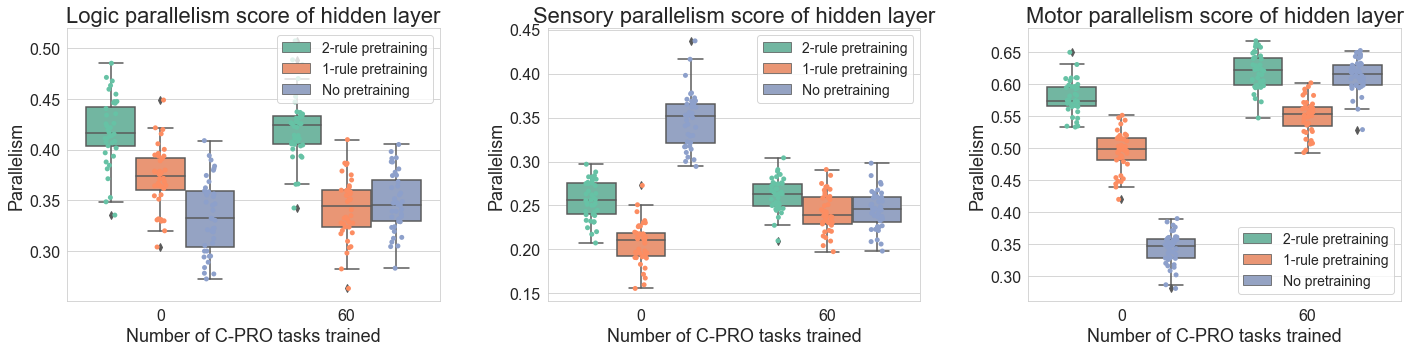

In [125]:
plt.figure(figsize=(20,5))
plt.subplot(131)
ax = sns.boxplot(x="NumPracticedTasks",y="LogicPSavg",hue='Training',palette='Set2',data=df_psavg0)
sns.stripplot(x="NumPracticedTasks",y="LogicPSavg",hue='Training',palette='Set2',dodge=True,data=df_psavg0)
plt.title('Logic parallelism score of hidden layer', fontsize=22)
plt.xlabel('Number of C-PRO tasks trained', fontsize=18)
plt.ylabel('Parallelism', fontsize=18)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
# plt.ylim([0,.5])
plt.legend()
# Get the handles and labels. For this example it'll be 2 tuples
# of length 4 each.
handles, labels = ax.get_legend_handles_labels()

# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:3], labels[0:3],fontsize=14)
# plt.ylim([0,.5])

plt.subplot(132)
ax = sns.boxplot(x="NumPracticedTasks",y="SensoryPSavg",hue='Training',palette='Set2',data=df_psavg0)
sns.stripplot(x="NumPracticedTasks",y="SensoryPSavg",hue='Training',palette='Set2',dodge=True,data=df_psavg0)
plt.title('Sensory parallelism score of hidden layer', fontsize=22)
plt.xlabel('Number of C-PRO tasks trained', fontsize=18)
plt.ylabel('Parallelism', fontsize=18)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
# plt.ylim([0,.5])
plt.legend()
# Get the handles and labels. For this example it'll be 2 tuples
# of length 4 each.
handles, labels = ax.get_legend_handles_labels()

# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:3], labels[0:3],fontsize=14)
# plt.ylim([0,.5])

plt.subplot(133)
ax = sns.boxplot(x="NumPracticedTasks",y="MotorPSavg",hue='Training',palette='Set2',data=df_psavg0)
sns.stripplot(x="NumPracticedTasks",y="MotorPSavg",hue='Training',palette='Set2',dodge=True,data=df_psavg0)
plt.title('Motor parallelism score of hidden layer', fontsize=22)
plt.xlabel('Number of C-PRO tasks trained', fontsize=18)
plt.ylabel('Parallelism', fontsize=18)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
# plt.ylim([0,.5])
plt.legend()
# Get the handles and labels. For this example it'll be 2 tuples
# of length 4 each.
handles, labels = ax.get_legend_handles_labels()

# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:3], labels[0:3],fontsize=14)
# plt.ylim([0,.5])



plt.tight_layout()
# plt.savefig('ModelPS.png', dpi=300)

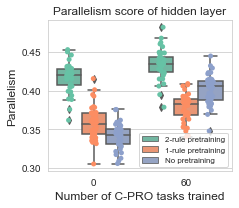

In [126]:
plt.figure(figsize=(3.5,3))
ax = sns.boxplot(x="NumPracticedTasks",y="PSavg",hue='Training',palette='Set2',data=df_psavg0)
sns.stripplot(x="NumPracticedTasks",y="PSavg",hue='Training',palette='Set2',dodge=True,data=df_psavg0)
plt.title('Parallelism score of hidden layer', fontsize=12)
plt.xlabel('Number of C-PRO tasks trained', fontsize=12)
plt.ylabel('Parallelism', fontsize=12)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10);
# plt.ylim([0,.5])
plt.legend()
# Get the handles and labels. For this example it'll be 2 tuples
# of length 4 each.
handles, labels = ax.get_legend_handles_labels()

# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:3], labels[0:3],fontsize=8)
# plt.ylim([0,.5])


plt.tight_layout()
# plt.savefig('ModelPS_Average.png', dpi=300)

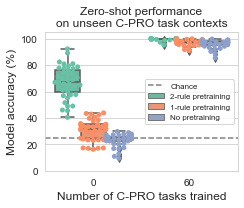

In [127]:
plt.figure(figsize=(3.5,3))
sns.boxplot(x="NumPracticedTasks",y="Accuracy",hue='Training',palette='Set2',data=df_psavg0)
ax = sns.swarmplot(x="NumPracticedTasks",y="Accuracy",hue='Training',palette='Set2',data=df_psavg0,dodge=True)
plt.plot(np.arange(-0.5,2.5),np.repeat(25.0,3),'gray',linestyle='--',label='Chance')
plt.title('Zero-shot performance\non unseen C-PRO task contexts', fontsize=12)
plt.xlabel('Number of C-PRO tasks trained', fontsize=12)
plt.ylabel('Model accuracy (%)', fontsize=12)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10);
# Get the handles and labels. For this example it'll be 2 tuples
# of length 4 each.
handles, labels = ax.get_legend_handles_labels()

# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:4], labels[0:4],fontsize=8)
plt.ylim([0,105])
plt.tight_layout()
# plt.savefig('ModelPerformance.png', dpi=300)

#### Look at PS for pretrained networks (zero-shot) for each rule separately

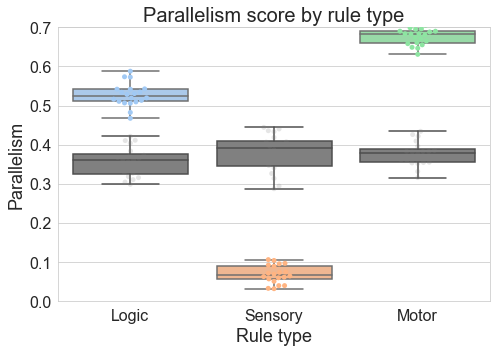

In [59]:
dfrule0 = {}
dfrule0['Parallelism score'] = []
dfrule0['Rule type'] = []
dfrule0['Simulation'] = []
dfrule0_notraining = {}
dfrule0_notraining['Parallelism score'] = []
dfrule0_notraining['Rule type'] = []
dfrule0_notraining['Simulation'] = []
for i in range(simstart,simend):
    # Get 0 practiced tasks data
    tmpdf = df_adam0.loc[df_adam0.Simulation==i]
    tmpdf = tmpdf.loc[tmpdf.NumPracticedTasks==0]
    dfrule0['Simulation'].append(i)
    dfrule0['Parallelism score'].append(tmpdf.LogicPS2.values[0])
    dfrule0['Rule type'].append('Logic')
    
    dfrule0['Simulation'].append(i)
    dfrule0['Parallelism score'].append(tmpdf.SensoryPS2.values[0])
    dfrule0['Rule type'].append('Sensory')
    
    dfrule0['Simulation'].append(i)
    dfrule0['Parallelism score'].append(tmpdf.MotorPS2.values[0])
    dfrule0['Rule type'].append('Motor')

    ## No training model
    tmpdf = df_adam0_nopretraining.loc[df_adam0_nopretraining.Simulation==i]
    tmpdf = tmpdf.loc[tmpdf.NumPracticedTasks==0]
    dfrule0_notraining['Simulation'].append(i)
    dfrule0_notraining['Parallelism score'].append(tmpdf.LogicPS2.values[0])
    dfrule0_notraining['Rule type'].append('Logic')
    
    dfrule0_notraining['Simulation'].append(i)
    dfrule0_notraining['Parallelism score'].append(tmpdf.SensoryPS2.values[0])
    dfrule0_notraining['Rule type'].append('Sensory')
    
    dfrule0_notraining['Simulation'].append(i)
    dfrule0_notraining['Parallelism score'].append(tmpdf.MotorPS2.values[0])
    dfrule0_notraining['Rule type'].append('Motor')
    
dfrule0 = pd.DataFrame(dfrule0)

plt.figure(figsize=(7,5))
sns.boxplot(x="Rule type",y="Parallelism score",data=dfrule0,palette='pastel')
sns.swarmplot(x="Rule type",y="Parallelism score",data=dfrule0,palette='pastel')
sns.boxplot(x="Rule type",y="Parallelism score",data=dfrule0_notraining,palette=['grey','grey','grey'])
sns.swarmplot(x="Rule type",y="Parallelism score",data=dfrule0_notraining,palette=['gray','gray','gray'],alpha=0.2)
plt.title('Parallelism score by rule type', fontsize=20)
plt.xlabel('Rule type', fontsize=18)
plt.ylabel('Parallelism', fontsize=18)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.ylim([0,.7])
plt.tight_layout()